In [59]:
import numpy as np
import pandas as pd
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import cv2
import shutil
import tensorflow as tf
import pytesseract as pt
import matplotlib.pyplot as plt
import plotly.express as px
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [60]:
path = "C:/Users/Sahand/Music/numberplate/images/"


In [61]:
labels_dict = dict(labelpath=[],imagepath=[], xmin=[], xmax=[], ymin=[], ymax=[] )
for file in sorted(os.listdir(path)):
# Debugging output
    if 'xml' in file:
        info = xet.parse(path + file)
        root = info.getroot()
        obj = root.find('object')
        l_info = obj.find('bndbox')
        xmin = int(l_info.find('xmin').text)
        xmax = int(l_info.find('xmax').text)
        ymin = int(l_info.find('ymin').text)
        ymax = int(l_info.find('ymax').text)

        labels_dict['labelpath'].append(path + file)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['imagepath'].append(path+file[:-3]+'jpeg')

In [62]:
df = pd.DataFrame(data=labels_dict)

In [63]:

df.head()

,labelpath,imagepath,xmin,xmax,ymin,ymax
0,C:/Users/Sahand/Music/numberplate/images/N1.xml,C:/Users/Sahand/Music/numberplate/images/N1.jpeg,1093,1396,645,727
1,C:/Users/Sahand/Music/numberplate/images/N100.xml,C:/Users/Sahand/Music/numberplate/images/N100....,134,301,312,350
2,C:/Users/Sahand/Music/numberplate/images/N101.xml,C:/Users/Sahand/Music/numberplate/images/N101....,31,139,128,161
3,C:/Users/Sahand/Music/numberplate/images/N102.xml,C:/Users/Sahand/Music/numberplate/images/N102....,164,316,216,243
4,C:/Users/Sahand/Music/numberplate/images/N103.xml,C:/Users/Sahand/Music/numberplate/images/N103....,813,1067,665,724


In [64]:
df.iloc[54,1]

'C:/Users/Sahand/Music/numberplate/images/N152.jpeg'

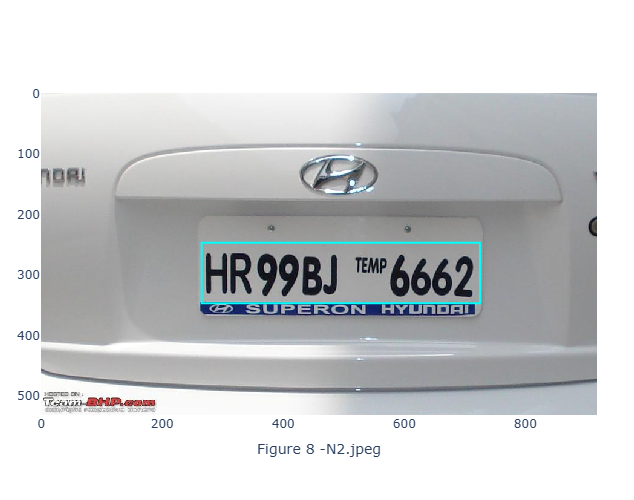

In [65]:
img = cv2.cvtColor(cv2.imread(df.iloc[54,1]) , cv2.COLOR_BGR2RGB)
xmin = df.iloc[54,2]
xmax = df.iloc[54,3]
ymin = df.iloc[54,4]
ymax = df.iloc[54,5]


fig = px.imshow(img)
fig.update_layout(width=600 , height=500 , margin=dict(l=10 , r=10 , b=10 , t=10) , xaxis_title='Figure 8 -N2.jpeg')
fig.add_shape(type='rect' , x0=xmin , x1=xmax , y0=ymin , y1=ymax , xref='x' , yref='y' , line_color='cyan')

fig.show()

In [66]:
df.iloc[1]

labelpath    C:/Users/Sahand/Music/numberplate/images/N100.xml
imagepath    C:/Users/Sahand/Music/numberplate/images/N100....
xmin                                                       134
xmax                                                       301
ymin                                                       312
ymax                                                       350
Name: 1, dtype: object

In [67]:
data =[]
output = []

for i in range(len(df)):
    image = df.iloc[i,1]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    load_image = load_img(image , target_size=(224 , 224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/225.0

    xmin , xmax , ymin , ymax = df.iloc[i][2:]
    nxmin , nxmax = xmin/w , xmax/w
    nymin , nymax = ymin/h , ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    data.append(norm_load_image_arr)
    output.append(label_norm)
    

In [68]:
print(norm_load_image_arr.shape)

(224, 224, 3)


In [69]:
x = np.array(data,dtype=np.float32)
y = np.array(output , dtype=np.float32)

In [70]:
x_train , x_test, y_train , y_test = train_test_split(x,y,train_size=0.8 , random_state=0)

In [71]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [72]:
inception_resnet = InceptionResNetV2(weights='inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5' , include_top=False , input_tensor=Input(shape=(224,224,3)))

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(600,activation=tf.keras.layers.LeakyReLU(negative_slope=0.01))(headmodel)
headmodel = Dense(300,activation=tf.keras.layers.LeakyReLU(negative_slope=0.01))(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input , outputs=headmodel)

In [76]:
model.compile(loss='mse' , optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [78]:
history = model.fit(x=x_train , y=y_train , batch_size=10 , epochs=100 , validation_data=(x_test , y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 536s 18s/step - loss: 0.0749 - val_loss: 0.0549
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 307s 17s/step - loss: 0.0488 - val_loss: 0.0545
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 320s 18s/step - loss: 0.0261 - val_loss: 0.0196
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 335s 19s/step - loss: 0.0102 - val_loss: 0.0123
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 397s 20s/step - loss: 0.0042 - val_loss: 0.0098
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 353s 20s/step - loss: 0.0028 - val_loss: 0.0093
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 385s 20s/step - loss: 0.0031 - val_loss: 0.0104
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 319s 18s/step - loss: 0.0031 - val_loss: 0.0099
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 360s 20s/step - loss: 0.0022 - val_loss: 0.0093
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 369s 21s/step - loss: 0.0022 - val_loss: 0.0081
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 357s 20s/step - loss: 0.0018 - val_loss: 0.0075
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3

<Axes: >

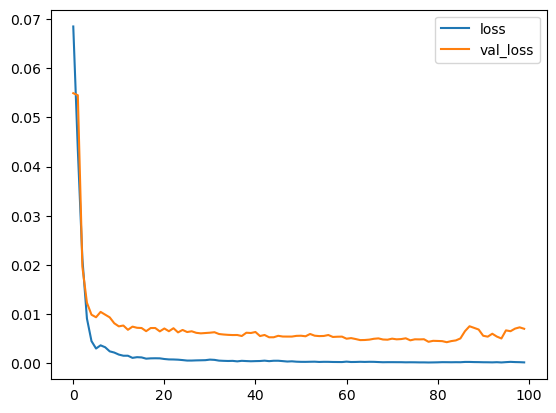

In [79]:
pd.DataFrame(history.history).plot()

In [147]:
image = 'C:/Users/Sahand/Music/numberplate/images/N32.jpeg'

In [148]:
img_arr = cv2.cvtColor(cv2.imread(image) , cv2.COLOR_BGR2RGB)
h,w,d = img_arr.shape
load_image = load_img(image , target_size=(224,224))
load_img_arr = img_to_array(load_image)
norm_load_image_arr = load_image_arr/255.0
print(norm_load_image_arr.shape)

(224, 224, 3)


In [149]:
x = np.array(norm_load_image_arr , dtype=np.float32).reshape(-1 ,224 ,224 ,3)

In [150]:
pred = model.predict(x , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


In [151]:
xmin = pred[0][0] * w
xmax = pred[0][1] * w
ymin = pred[0][2] * h
ymax = pred[0][3] * h

In [100]:
model.save('NPD.h5')

In [115]:
import matplotlib.patches as patches

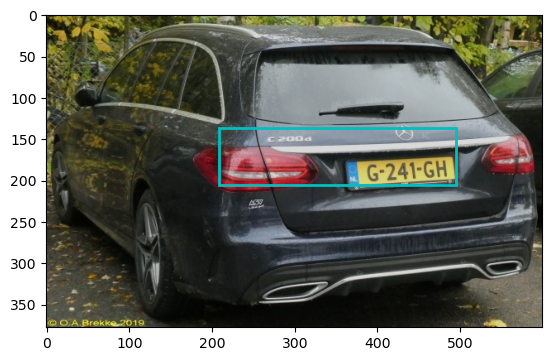

In [152]:
fig , ax = plt.subplots()
ax.imshow(img_arr)
rect = patches.Rectangle((xmin , ymin) , xmax-xmin , ymax-ymin , linewidth=2 , edgecolor='c' , facecolor='none')

ax.add_patch(rect)
plt.savefig('test.jpeg')
plt.show()
